# AutoEncoder

Make a shallow autoencoder with single hidden layer.

In [44]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

Load dataset (MNIST)

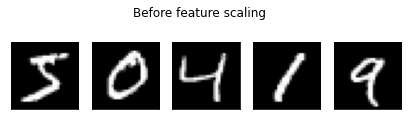

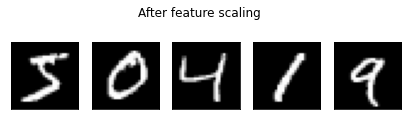

In [45]:
plt.style.use({'figure.facecolor':'white'}) # PyCharm Jupyter background 문제

mnist_dataset = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist_dataset.load_data()
m, rows, cols = x_train.shape

# Flatten
x_train = tf.cast(tf.reshape(x_train, [x_train.shape[0], -1]), tf.float32)
x_test = tf.cast(tf.reshape(x_test, [x_test.shape[0], -1]), tf.float32)

# load 된 데이터 확인
n = 5
fig = plt.figure(figsize=(7, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1) # (nrows, ncols, index), index starts at 1 in the upper left corner.
    plt.imshow(tf.reshape(x_train[i],[rows, cols]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig.suptitle('Before feature scaling')
plt.show()

# Feature scaling (min-max)
max_val = np.amax(x_train, axis=1, keepdims=True)
min_val = np.amin(x_train, axis=1, keepdims=True)
x_train = (x_train - min_val)/(max_val - min_val)

max_val = np.amax(x_test, axis=1, keepdims=True)
min_val = np.amin(x_test, axis=1, keepdims=True)
x_test = (x_test - min_val)/(max_val - min_val)

# Feature scaling -> 올바르게 진행되었는지 이미지로 확인
n = 5
fig = plt.figure(figsize=(7, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1) # (nrows, ncols, index), index starts at 1 in the upper left corner.
    plt.imshow(tf.reshape(x_train[i],[rows, cols]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig.suptitle('After feature scaling')
plt.show()

Hyper-parameters 설정

In [46]:
learning_rate = 0.5
epochs = 10
batch_size = 64       # going to use Mini-batch GD
input_size = cols * rows

Auto-encoder 신경망 구성

`tf.Tensor`를 그냥 사용하지 않고 `tf.Variable`을 사용하는 이유
* `tf.Variable`은 `tf.Tensor`의 wrapper로,
`run`과 같은 multiple calls(for backpropagation)에서 variable의 값을 지속적으로 추적하기 위해 사용
* Optimizer가 Tensor를 variable로 변환하지 않는 수고를 덜기위해
    * variable을 통해 모델의 학습 가능한(trainable) parameter들을 명시해줄 수 있다.
    * `tf.Tensor`는 모델의 입력이나 중간 출력(intermediate representations)으로 생각할 수 있다.

모델과 레이어 정의에는 `tf.Module` 사용을 권장한다.

In [47]:
class AutoEncoderModule(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        # input weights and bias / output weights and bias (no hidden layer)
        self.ip_w = tf.Variable(tf.random.normal(shape=[rows * cols, (rows * cols) // 2]), name="input_weights")
        self.ip_b = tf.Variable(tf.zeros([1,1]))
        self.op_w = tf.Variable(tf.random.normal(shape=[(rows * cols) // 2, rows * cols]), name="output_weights")
        self.op_b = tf.Variable(tf.zeros([1,1]))
    def __call__(self, x):
        output = tf.matmul(x, self.ip_w) + self.ip_b
        output = tf.nn.relu(output)
        output = tf.matmul(output, self.op_w) + self.op_b
        output = tf.sigmoid(output)
        return output

Loss function 정의: L2 loss (MSE)

In [48]:
def mse(t_y, p_y):
    return tf.reduce_mean(tf.square(t_y - p_y))

학습 함수 (train 함수 정의)

In [49]:
def train_sgd(model : AutoEncoderModule, x, y, lr: float, loss_fn):
    with tf.GradientTape() as t:
        # 학습 가능한 variable들은 GradientTape에 의해 자동적으로 추적됨
        loss = loss_fn(y, model(x))
    d_iw, d_ib, d_ow, d_ob = t.gradient(loss, [model.ip_w, model.ip_b, model.op_w, model.op_b])

    model.ip_w.assign_sub(lr * d_iw)
    model.ip_b.assign_sub(lr * d_ib)
    model.op_w.assign_sub(lr * d_ow)
    model.op_b.assign_sub(lr * d_ob)

학습 알고리즘 함수 (training_loop 함수 정의, 어떻게 학습 시킬것인지)

In [50]:
def training_loop(model, x, y, train_fn, lr, bs, es) -> list:
    """
    mini-batch gradient descent를 이용한 학습

    :param model: 학습할 모델 (오토인코더)
    :param x: 학습 데이터
    :param y: 타겟 데이터
    :param train_fn: 훈련에 사용할 함수
    :param lr: 학습률
    :param bs: 배치 사이즈
    :param es: 학습 횟수 (epochs)
    :return: 일정 간격에 따른 loss 측정 값을 저장한 list
    """
    ls = []
    loss_avg = []
    x_m, _ = x.shape
    if x_m % bs == 0:
        total_step = x_m // bs
    else:
        total_step = x_m // bs

    for epoch in range(es):
        loss_avg.clear()
        for j in range(total_step):
            if j != total_step - 1:
                sliced_x = x[j * bs: (j + 1) * bs]
                sliced_y = y[j * bs: (j + 1) * bs]
            else:
                sliced_x = x[j * bs: ]
                sliced_y = y[j * bs: ]
            train_fn(model, sliced_x, sliced_y, lr, mse)
            loss_avg.append(mse(sliced_y, model(sliced_x)))
        avg_loss = np.average(loss_avg)
        ls.append(avg_loss)
        print('{}) loss: {}'.format(epoch, avg_loss))
    return ls

학습 시작

In [51]:
ae_model = AutoEncoderModule()
loss_output = training_loop(ae_model,x_train, x_train, train_sgd, learning_rate, batch_size, epochs)

0) loss: 0.44698190689086914
1) loss: 0.3871338665485382
2) loss: 0.33397793769836426
3) loss: 0.2889673411846161
4) loss: 0.2528367340564728
5) loss: 0.22499971091747284
6) loss: 0.20431292057037354
7) loss: 0.1897539496421814
8) loss: 0.1792910099029541
9) loss: 0.17132849991321564


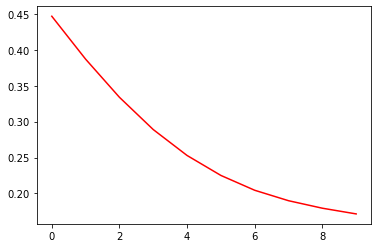

In [52]:
plt.plot(range(epochs), loss_output, "r")
plt.show()

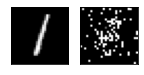

In [53]:
test_output = ae_model(x_test[0:5])

fig = plt.figure(figsize=(6, 2))
for i in range(2):
    ax = plt.subplot(1, n, i + 1) # (nrows, ncols, index), index starts at 1 in the upper left corner.
    if i == 0:
        plt.imshow(tf.reshape(x_test[2],[rows, cols]))
    else:
        plt.imshow(tf.reshape(test_output[2],[rows, cols]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.imshow(tf.reshape(test_output[0], [rows, cols]))

Hidden Layer가 없는 오토인코더는 성능이 낮다. Hidden layer를 추가해보자.


In [54]:
from AutoEncoder import AutoEncoderModule
layer_size_list = [input_size, input_size // 2]
learning_rate = 0.01
epochs = 50
batch_size = 256       # going to use Mini-batch GD

In [55]:
deep_ae = AutoEncoderModule(layer_size_list)
loss_output = training_loop(deep_ae, x_train, x_train, deep_ae.train, learning_rate, batch_size, epochs)
plt.plot(range(epochs), loss_output, "r")
plt.show()






TypeError: 'list_reverseiterator' object is not subscriptable